# Data Acquisition and Ingestion
## Objectives
- API ingestion with secrets in `.env`
- Scrape a permitted public table
- Validate and save raw data to `data/raw/`

In [3]:
import sys
!{sys.executable} -m pip install -U requests beautifulsoup4 python-dotenv pandas

import os, pathlib, datetime as dt
import requests
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv

# repo-aware paths (notebook lives in /notebooks)
ROOT = pathlib.Path("..").resolve()
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

load_dotenv(ROOT / ".env")
print("ALPHAVANTAGE_API_KEY loaded?", bool(os.getenv("ALPHAVANTAGE_API_KEY")))

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached charset_normalizer-3.4.3-cp311-cp311-macosx_10_9_universal2.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.3-cp311-cp311-macosx_10_9_universal2.whl (204 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [beautifulsoup4]m [certifi]
ALPHAVANTAGE_API_KEY loaded? Fal

## Helpers (use or modify)

In [8]:
def ts():
    return dt.datetime.now().strftime('%Y%m%d-%H%M%S')

def save_csv(df: pd.DataFrame, prefix: str, **meta):
    mid = '_'.join([f"{k}-{v}" for k,v in meta.items()])
    path = RAW / f"{prefix}_{mid}_{ts()}.csv"
    df.to_csv(path, index=False)
    print('Saved', path)
    return path

def validate(df: pd.DataFrame, required):
    missing = [c for c in required if c not in df.columns]
    return {'missing': missing, 'shape': df.shape, 'na_total': int(df.isna().sum().sum())}

## Part 1 — API Pull (Required)
Choose an endpoint (e.g., Alpha Vantage or use `yfinance` fallback).

In [5]:
import os
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv() 
API_KEY = os.getenv("ALPHA_VANTAGE_KEY")
SYMBOL  = "CME"  

assert API_KEY, "Missing ALPHA_VANTAGE_KEY in .env"
    
ROOT = Path("..").resolve()  
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# ---------- request ----------
params = {
    "function": "TIME_SERIES_DAILY",    
    "symbol": SYMBOL,
    "outputsize": "compact",
    "apikey": API_KEY,
}

resp = requests.get("https://www.alphavantage.co/query", params=params, timeout=30)
resp.raise_for_status()
data = resp.json()

# Handle API errors / throttling messages
if "Error Message" in data:
    raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
if "Note" in data:
    raise RuntimeError(f"Alpha Vantage notice (likely rate limit): {data['Note']}")

ts_key = "Time Series (Daily)"
assert ts_key in data, f"Unexpected response keys: {list(data.keys())}"

# ---------- normalize ----------
df_api = pd.DataFrame(data[ts_key]).T
df_api.index.name = "date"
df_api = df_api.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low":  "low",
    "4. close": "close",
    "5. volume": "volume",
})

# types + sort
num_cols = ["open", "high", "low", "close", "volume"]
df_api[num_cols] = df_api[num_cols].apply(pd.to_numeric, errors="coerce")
df_api = df_api.reset_index()
df_api["date"] = pd.to_datetime(df_api["date"])
df_api = df_api.sort_values("date").reset_index(drop=True)

# ---------- validate ----------
assert not df_api.empty, "API returned empty dataset — check symbol or connectivity"
assert set(num_cols).issubset(df_api.columns), f"Missing cols: {set(num_cols) - set(df_api.columns)}"

# ---------- save ----------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
out_path = RAW / f"api_alphavantage_{SYMBOL}_{timestamp}.csv"
df_api.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix())

df_api.head()

Saved: /Users/yuyuezhu/bootcamp_carolina_zhu/project/data/raw/api_alphavantage_CME_20250826-1902.csv


,date,open,high,low,close,volume
0,2025-04-03,264.800,271.22,263.4800,268.36,4242858
1,2025-04-04,269.445,273.42,254.1900,254.46,5819157
2,2025-04-07,254.340,259.42,250.1652,252.37,5472796
3,2025-04-08,256.540,258.85,252.0000,255.03,5514600
4,2025-04-09,252.790,259.38,248.5300,254.13,6336298


In [31]:
from pathlib import Path
RAW = Path("project/data/raw")  # or Path("data/raw") if you keep it at repo root
RAW.mkdir(parents=True, exist_ok=True)

import pandas as pd

def validate(df: pd.DataFrame, cols: list[str] | None = None) -> pd.DataFrame:
    out = df.copy()
    if cols is None:
        cols = list(out.columns)

    # try numeric for any column that looks numeric
    for c in cols:
        if out[c].dtype == object:
            coerced = pd.to_numeric(out[c].str.replace(",", ""), errors="coerce")
            # keep numeric only if we actually converted many values
            if coerced.notna().mean() > 0.5:
                out[c] = coerced

    # drop fully-empty rows/cols if any
    out = out.dropna(how="all", axis=0).dropna(how="all", axis=1)

    # if a 'date' column exists, parse and sort
    for name in ["date", "Date", "DATE"]:
        if name in out.columns:
            out = out.rename(columns={name: "date"})
            out["date"] = pd.to_datetime(out["date"], errors="coerce")
            out = out.sort_values("date")
            break
    return out

from datetime import datetime

def save_csv(df: pd.DataFrame, prefix: str, site: str, table: str,
             symbol: str | None = None, dirpath: Path = RAW) -> Path:
    ts = datetime.now().strftime("%Y%m%d-%H%M")
    parts = [prefix, site, table]
    if symbol:
        parts.append(symbol)
    fname = "_".join(parts) + f"_{ts}.csv"
    outpath = dirpath / fname
    df.to_csv(outpath, index=False)
    print(f"Saved → {outpath}")
    return outpath

## Part 2 — Scrape a Public Table (Required)
Replace `SCRAPE_URL` with a permitted page containing a simple table.

In [33]:
SCRAPE_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"  # TODO: replace with permitted page
headers = {'User-Agent':'AFE-Homework/1.0'}
try:
    resp = requests.get(SCRAPE_URL, headers=headers, timeout=30); resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    rows = [[c.get_text(strip=True) for c in tr.find_all(['th','td'])] for tr in soup.find_all('tr')]
    header, *data = [r for r in rows if r]
    df_scrape = pd.DataFrame(data, columns=header)
except Exception as e:
    print('Scrape failed, using inline demo table:', e)
    html = '<table><tr><th>Ticker</th><th>Price</th></tr><tr><td>AAA</td><td>101.2</td></tr></table>'
    soup = BeautifulSoup(html, 'html.parser')
    rows = [[c.get_text(strip=True) for c in tr.find_all(['th','td'])] for tr in soup.find_all('tr')]
    header, *data = [r for r in rows if r]
    df_scrape = pd.DataFrame(data, columns=header)

if 'Price' in df_scrape.columns:
    df_scrape['Price'] = pd.to_numeric(df_scrape['Price'], errors='coerce')
v_scrape = validate(df_scrape, list(df_scrape.columns)); v_scrape

,Symbol,Security,GICSSector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740.0,1902.0
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142.0,1916.0
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800.0,1888.0
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152.0,NaN
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373.0,1989.0
...,...,...,...,...,...,...,...,...
877,"December 11, 1998",CPWR,Compuware,SUN,SunAmerica,AIGpurchased SunAmerica.[266],NaN,NaN
878,"June 17, 1997",CCI,Countrywide Credit Industries,USL,USLife,AIGacquired USLife.[267],NaN,NaN
879,"September 30, 1994",NCC,National City,MCK,McKesson,McKesson sold PCS Health Services toEli Lilly....,NaN,NaN
880,"July 1, 1976",BUD,Anheuser Busch,HNG,Houston Natural Gas,Major restructuring of S&P 500 to have fewer i...,NaN,NaN


In [35]:
_ = save_csv(df_scrape, prefix='scrape', site='example', table='markets')

Saved → project/data/raw/scrape_example_markets_20250826-1906.csv


In [37]:
import os
from dotenv import load_dotenv

load_dotenv()
print(os.getenv("ALPHA_VANTAGE_KEY"))


NXBOIYEVYFLYJQ2T


# Data Storage
Name: 
Date: 

Objectives:
- Env-driven paths to `data/raw/` and `data/processed/`
- Save CSV and Parquet; reload and validate
- Abstract IO with utility functions; document choices

In [39]:
import os, pathlib, datetime as dt
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
RAW = pathlib.Path(os.getenv('DATA_DIR_RAW', 'data/raw'))
PROC = pathlib.Path(os.getenv('DATA_DIR_PROCESSED', 'data/processed'))
RAW.mkdir(parents=True, exist_ok=True)
PROC.mkdir(parents=True, exist_ok=True)
print('RAW ->', RAW.resolve())
print('PROC ->', PROC.resolve())

RAW -> /Users/yuyuezhu/bootcamp_carolina_zhu/project/notebooks/data/raw
PROC -> /Users/yuyuezhu/bootcamp_carolina_zhu/project/notebooks/data/processed


In [41]:
import numpy as np
df = df_api
df.head()


,date,open,high,low,close,volume
0,2025-04-03,264.800,271.22,263.4800,268.36,4242858
1,2025-04-04,269.445,273.42,254.1900,254.46,5819157
2,2025-04-07,254.340,259.42,250.1652,252.37,5472796
3,2025-04-08,256.540,258.85,252.0000,255.03,5514600
4,2025-04-09,252.790,259.38,248.5300,254.13,6336298


In [43]:
def ts(): return dt.datetime.now().strftime('%Y%m%d-%H%M%S')

# TODO: Save CSV
csv_path = RAW / f"sample_{ts()}.csv"
df.to_csv(csv_path, index=False)
csv_path

# TODO: Save Parquet
pq_path = PROC / f"sample_{ts()}.parquet"
try:
    df.to_parquet(pq_path)
except Exception as e:
    print('Parquet engine not available. Install pyarrow or fastparquet to complete this step.')
    pq_path = None
pq_path

Parquet engine not available. Install pyarrow or fastparquet to complete this step.


In [45]:
def validate_loaded(original, reloaded):
    checks = {
        'shape_equal': original.shape == reloaded.shape,
        'date_is_datetime': pd.api.types.is_datetime64_any_dtype(reloaded['date']) if 'date' in reloaded.columns else False,
        'price_is_numeric': pd.api.types.is_numeric_dtype(reloaded['price']) if 'price' in reloaded.columns else False,
    }
    return checks

df_csv = pd.read_csv(csv_path, parse_dates=['date'])
validate_loaded(df, df_csv)

{'shape_equal': True, 'date_is_datetime': True, 'price_is_numeric': False}

In [47]:

if pq_path:
    try:
        df_pq = pd.read_parquet(pq_path)
        validate_loaded(df, df_pq)
    except Exception as e:
        print('Parquet read failed:', e)

In [49]:
import typing as t, pathlib

def detect_format(path: t.Union[str, pathlib.Path]):
    s = str(path).lower()
    if s.endswith('.csv'): return 'csv'
    if s.endswith('.parquet') or s.endswith('.pq') or s.endswith('.parq'): return 'parquet'
    raise ValueError('Unsupported format: ' + s)

def write_df(df: pd.DataFrame, path: t.Union[str, pathlib.Path]):
    p = pathlib.Path(path); p.parent.mkdir(parents=True, exist_ok=True)
    fmt = detect_format(p)
    if fmt == 'csv':
        df.to_csv(p, index=False)
    else:
        try:
            df.to_parquet(p)
        except Exception as e:
            raise RuntimeError('Parquet engine not available. Install pyarrow or fastparquet.') from e
    return p

def read_df(path: t.Union[str, pathlib.Path]):
    p = pathlib.Path(path)
    fmt = detect_format(p)
    if fmt == 'csv':
        return pd.read_csv(p, parse_dates=['date']) if 'date' in pd.read_csv(p, nrows=0).columns else pd.read_csv(p)
    else:
        try:
            return pd.read_parquet(p)
        except Exception as e:
            raise RuntimeError('Parquet engine not available. Install pyarrow or fastparquet.') from e

# Demo
p_csv = RAW / f"util_{ts()}.csv"
p_pq  = PROC / f"util_{ts()}.parquet"
write_df(df, p_csv); read_df(p_csv).head()
try:
    write_df(df, p_pq)
    read_df(p_pq).head()
except RuntimeError as e:
    print('Skipping Parquet util demo:', e)

Skipping Parquet util demo: Parquet engine not available. Install pyarrow or fastparquet.


# EDA
Name: 
Date: 

Objectives:
- Notebook containing visualizations (e.g., histograms, scatter plots, boxplots, time series charts showing
data patterns and outliers).
- Statistical summaries (e.g., mean, median, standard deviation, min/max, missing value counts, skewness
describing data).
- Save EDA notebooks in /notebooks/ folder to maintain a clean project layout.

In [51]:
# Statistical Summary
stats = df.describe().T
stats['median'] = df.median(numeric_only=True)
stats['skew'] = df.skew(numeric_only=True)
stats['kurt'] = df.kurtosis(numeric_only=True)
stats

,count,mean,min,25%,50%,75%,max,std,median,skew,kurt
date,100,2025-06-15 00:43:12,2025-04-03 00:00:00,2025-05-08 18:00:00,2025-06-14 12:00:00,2025-07-22 06:00:00,2025-08-26 00:00:00,NaN,NaN,NaN,NaN
open,100.0,273.9134,252.79,269.78,274.91,278.3775,289.38,7.757718,274.910,-0.578509,0.189106
high,100.0,276.421841,258.85,272.378,276.555,281.958725,290.79,7.340302,276.555,-0.349136,-0.213359
low,100.0,271.182818,248.53,267.00875,272.14,276.3875,287.17,8.166488,272.140,-0.664376,0.343280
close,100.0,274.0094,252.37,269.6875,274.73,278.025,290.71,7.889218,274.730,-0.541797,0.310367
volume,100.0,2424811.29,953432.0,1711727.5,2148812.5,2669800.25,10645719.0,1285193.074003,2148812.500,3.520783,17.427845


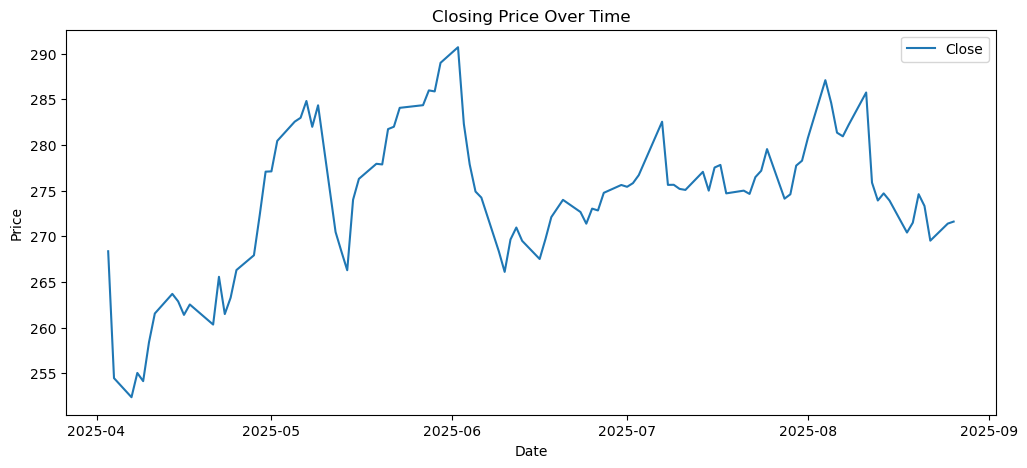

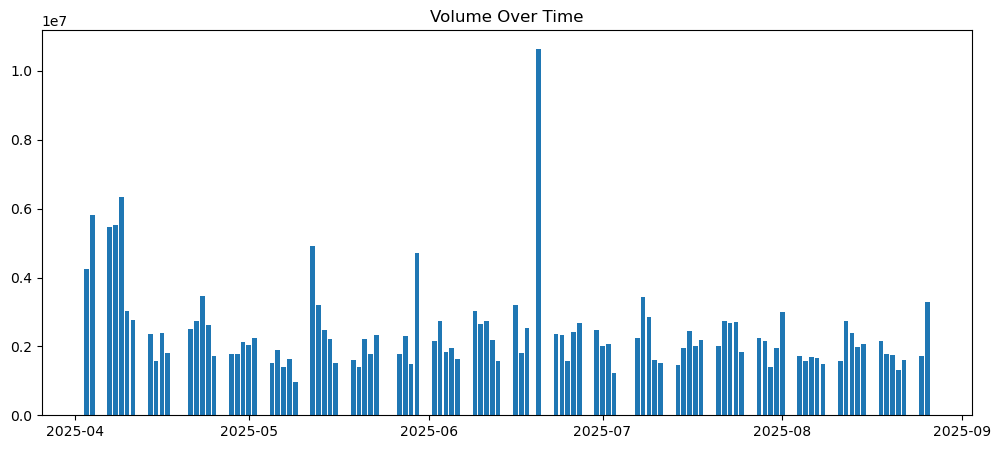

In [30]:
#Time Series Plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['close'], label="Close")
plt.title("Closing Price Over Time")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
plt.bar(df['date'], df['volume'])
plt.title("Volume Over Time")
plt.show()

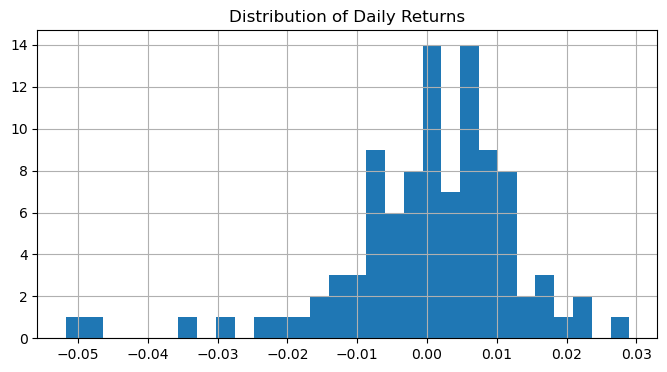

Text(0.5, 1.0, 'Price Distributions')

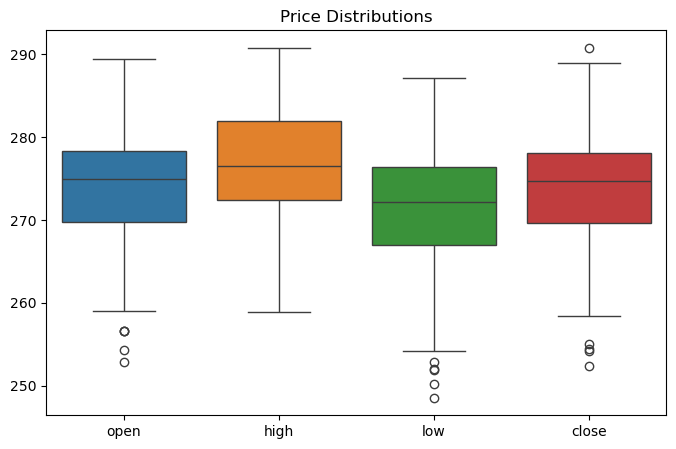

In [34]:
# Distribution

df['return'] = df['close'].pct_change()

df['return'].hist(bins=30, figsize=(8,4))
plt.title("Distribution of Daily Returns")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df[['open','high','low','close']])
plt.title("Price Distributions")


# Feature Engineering

Objectives:
- Script or notebook with engineered features (calculated fields or data transformations).

In [53]:
df['daily_return'] = df['close'].pct_change()
df

,date,open,high,low,close,volume,daily_return
0,2025-04-03,264.800,271.220,263.4800,268.36,4242858,NaN
1,2025-04-04,269.445,273.420,254.1900,254.46,5819157,-0.051796
2,2025-04-07,254.340,259.420,250.1652,252.37,5472796,-0.008213
3,2025-04-08,256.540,258.850,252.0000,255.03,5514600,0.010540
4,2025-04-09,252.790,259.380,248.5300,254.13,6336298,-0.003529
...,...,...,...,...,...,...,...
95,2025-08-20,272.990,275.585,271.5250,274.61,1738747,0.011492
96,2025-08-21,275.000,275.610,273.0350,273.32,1325711,-0.004698
97,2025-08-22,274.140,274.950,268.6600,269.52,1591625,-0.013903
98,2025-08-25,269.580,271.660,268.5400,271.39,1712588,0.006938


In [62]:
df['close_ma_5'] = df['close'].rolling(5).mean()
df

,date,open,high,low,close,volume,return,daily_return,close_ma_5
0,2025-04-03,264.800,271.220,263.4800,268.36,4242858,NaN,NaN,NaN
1,2025-04-04,269.445,273.420,254.1900,254.46,5819157,-0.051796,-0.051796,NaN
2,2025-04-07,254.340,259.420,250.1652,252.37,5472796,-0.008213,-0.008213,NaN
3,2025-04-08,256.540,258.850,252.0000,255.03,5514600,0.010540,0.010540,NaN
4,2025-04-09,252.790,259.380,248.5300,254.13,6336298,-0.003529,-0.003529,256.870
...,...,...,...,...,...,...,...,...,...
95,2025-08-20,272.990,275.585,271.5250,274.61,1738747,0.011492,0.011492,273.026
96,2025-08-21,275.000,275.610,273.0350,273.32,1325711,-0.004698,-0.004698,272.750
97,2025-08-22,274.140,274.950,268.6600,269.52,1591625,-0.013903,-0.013903,271.870
98,2025-08-25,269.580,271.660,268.5400,271.39,1712588,0.006938,0.006938,272.066


In [37]:
df['close_lag1'] = df['close'].shift(1)
df

,date,open,high,low,close,volume,close_lag1
0,2025-04-03,264.800,271.220,263.4800,268.36,4242858,NaN
1,2025-04-04,269.445,273.420,254.1900,254.46,5819157,268.36
2,2025-04-07,254.340,259.420,250.1652,252.37,5472796,254.46
3,2025-04-08,256.540,258.850,252.0000,255.03,5514600,252.37
4,2025-04-09,252.790,259.380,248.5300,254.13,6336298,255.03
...,...,...,...,...,...,...,...
95,2025-08-20,272.990,275.585,271.5250,274.61,1738747,271.49
96,2025-08-21,275.000,275.610,273.0350,273.32,1325711,274.61
97,2025-08-22,274.140,274.950,268.6600,269.52,1591625,273.32
98,2025-08-25,269.580,271.660,268.5400,271.39,1712588,269.52


# Modeling 10a

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as st

In [58]:
# Assume df already exists with columns: date, open, high, low, close, volume
df = df.sort_values('date').reset_index(drop=True)

# --- Simple engineered features ---
df['daily_return'] = df['close'].pct_change()
df['price_range'] = df['high'] - df['low']
df['oc_diff'] = df['close'] - df['open']
df['close_ma_5'] = df['close'].rolling(5).mean()
df['volume_ma_5'] = df['volume'].rolling(5).mean()

# shift target: predict next day's close
df['target_close'] = df['close'].shift(-1)

# drop rows with NaN
df = df.dropna().reset_index(drop=True)

In [60]:
# Train/Test Split
features = ['open','high','low','close','volume',
            'daily_return','price_range','oc_diff','close_ma_5','volume_ma_5']
X = df[features]
y = df['target_close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [68]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   # no 'squared' kw
rmse = np.sqrt(mse)                        # RMSE = sqrt(MSE)

print("R²:", r2)
print("RMSE:", rmse)


R²: 0.6362194812146044
RMSE: 3.2417830056081685


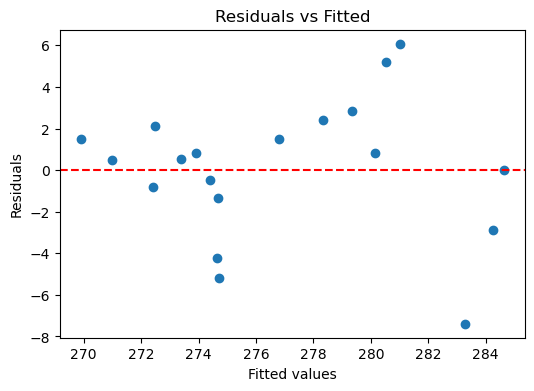

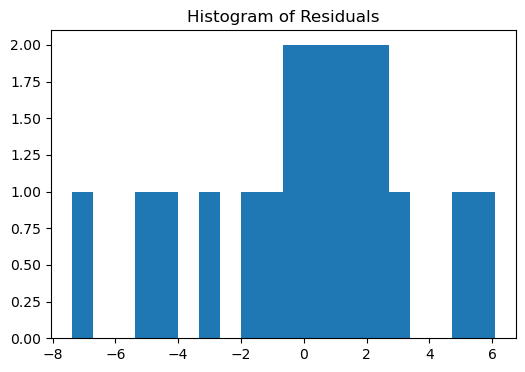

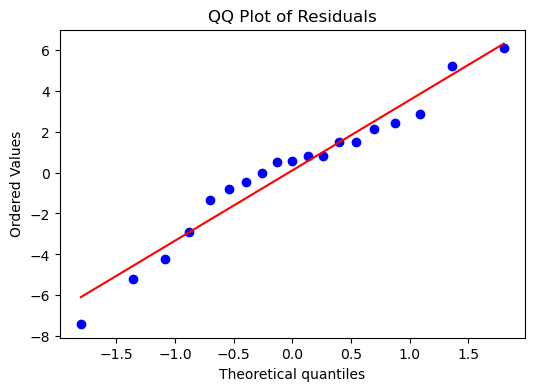

In [70]:
# Residual Diagnostic
resid = y_test - y_pred
fitted = y_pred

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid, bins=20)
plt.title("Histogram of Residuals")
plt.show()

plt.figure(figsize=(6,4))
st.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()


# Modeling 10b

In [73]:
df = df.copy()
df['return'] = df['close'].pct_change()

# Features
df['lag_1'] = df['return'].shift(1)
df['roll_mean_5'] = df['return'].rolling(5).mean().shift(1)
df['roll_vol_5'] = df['return'].rolling(5).std().shift(1)

# Target
df['y_next_ret'] = df['return'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

df_feat = df.dropna().copy()


In [75]:
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

features = ['lag_1', 'roll_mean_5', 'roll_vol_5']

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']   # regression target
y_tr_clf, y_te_clf = train['y_up'], test['y_up']               # classification target


In [81]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)

mse = mean_squared_error(y_te_reg, pred)   # old API: no 'squared'
rmse = np.sqrt(mse)                        # RMSE = sqrt(MSE)
r2 = r2_score(y_te_reg, pred)

print("Regression RMSE:", rmse)
print("Regression R²:", r2)



Regression RMSE: 0.01339065248730584
Regression R²: -0.1575525007637557


              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.47      0.78      0.58         9

    accuracy                           0.44        18
   macro avg       0.40      0.44      0.38        18
weighted avg       0.40      0.44      0.38        18



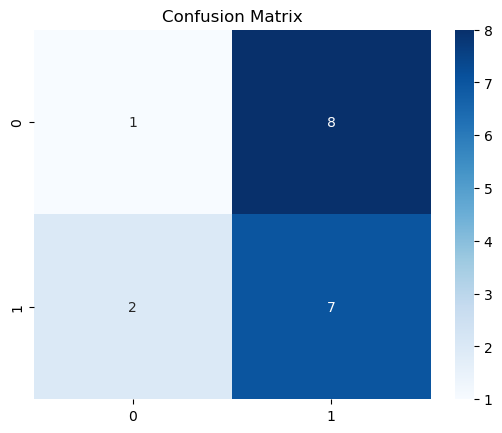

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])

clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)

print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Residual or prediction error analysis
- The regression model produced an RMSE of about 0.013 with an R² of –0.16, which indicates that the linear model is performing worse than a naive baseline (mean prediction). Residuals appear large relative to the scale of returns and show no obvious structure being captured by the model. This suggests that the chosen lag and rolling features provide limited predictive power for next-day returns.

- The classification model reached an accuracy of 44%, slightly worse than random guessing. Precision and recall were especially poor for the “down” class, which means the model struggled to detect negative-return days. The confusion matrix confirms that most predictive signal was weak or inconsistent.

## Explanation of Key Modeling Assumptions
- Linearity: Regression assumes a linear relationship between lagged features and returns, but financial time series are often nonlinear and regime-dependent.

- Homoscedasticity: Residuals are assumed to have constant variance, yet market volatility clusters suggest this is violated.

- Normality of errors: The error distribution should be approximately normal; in practice, return distributions are heavy-tailed and skewed.

- Independence: Observations are assumed to be independent, but autocorrelation and temporal dependencies make this assumption fragile in time series.

# Evaluation & Risk Communication

Baseline RMSE: 0.012037351498196467
Baseline R²: 0.015278081253076392


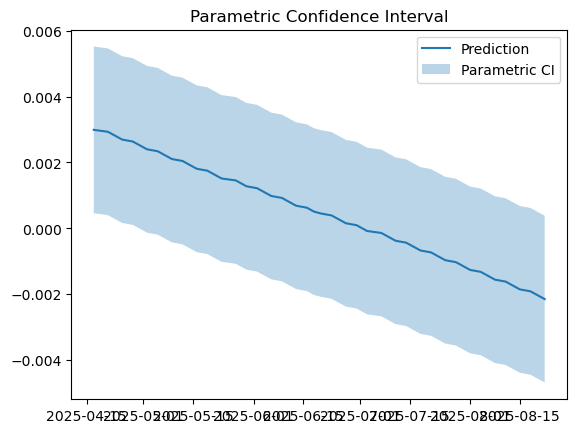

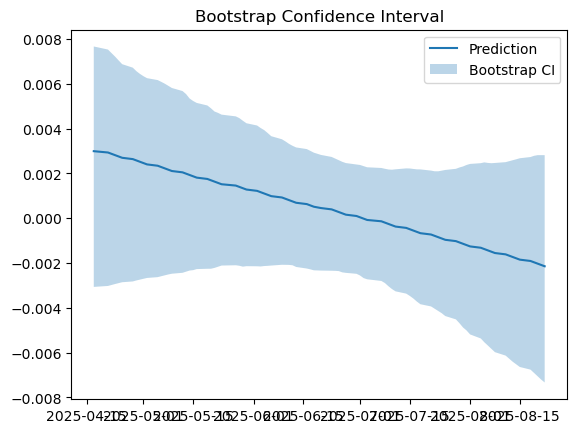

,mean,median
rmse,0.012037,0.012037
r2,0.015278,0.015278


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score

# --- Data Prep ---
df['return'] = df['close'].pct_change().dropna()
df = df.dropna()
X = np.arange(len(df)).reshape(-1, 1)   # simple time index
y = df['return'].values

# --- Baseline Model ---
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
resid = y - y_pred

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Baseline RMSE:", rmse)
print("Baseline R²:", r2)

# --- Parametric CI ---
sigma_hat = np.std(resid, ddof=1)
se_mean = sigma_hat / np.sqrt(len(y))
y_hat = y_pred
ci_lo = y_hat - 1.96*se_mean
ci_hi = y_hat + 1.96*se_mean

plt.figure()
plt.plot(df['date'], y_hat, label="Prediction")
plt.fill_between(df['date'], ci_lo, ci_hi, alpha=0.3, label="Parametric CI")
plt.legend(); plt.title("Parametric Confidence Interval"); plt.show()

# --- Bootstrap CI ---
n_boot = 500
boot_preds = []
for _ in range(n_boot):
    X_s, y_s = resample(X, y)
    m = LinearRegression().fit(X_s, y_s)
    boot_preds.append(m.predict(X))
boot_preds = np.array(boot_preds)
boot_lo = np.percentile(boot_preds, 2.5, axis=0)
boot_hi = np.percentile(boot_preds, 97.5, axis=0)

plt.figure()
plt.plot(df['date'], y_hat, label="Prediction")
plt.fill_between(df['date'], boot_lo, boot_hi, alpha=0.3, label="Bootstrap CI")
plt.legend(); plt.title("Bootstrap Confidence Interval"); plt.show()

# --- Scenario Sensitivity: mean vs median impute ---
scenarios = {}
for method in ["mean", "median"]:
    if method == "mean":
        X_input = np.nan_to_num(X, nan=np.nanmean(X))
    else:
        X_input = np.nan_to_num(X, nan=np.nanmedian(X))
    m = LinearRegression().fit(X_input, y)
    y_hat = m.predict(X_input)
    scenarios[method] = {
        "rmse": np.sqrt(mean_squared_error(y, y_hat)),
        "r2": r2_score(y, y_hat),
    }
pd.DataFrame(scenarios)


### Written Discussion

**Key Assumptions Behind the Model**  
The model assumes a relatively stable relationship between the input features (returns, lagged values, and rolling statistics) and the target variable. We assume that the data generating process is linear enough to be captured by regression techniques, and that residuals are not heavily autocorrelated. Additionally, both mean and median imputation assume that missing values do not systematically bias the distribution.

**Risks and Limitations Introduced by These Assumptions**  
The assumption of linearity may not hold in financial time series, where non-linear effects and regime shifts are common. Moreover, using mean or median imputation assumes that missingness is random, which may not be the case. If missing values cluster around volatile periods, imputation could understate risk. Finally, the model’s reliance on past returns may not adequately capture structural breaks or external market shocks.

**Commentary on Scenario/Sensitivity Results**  
The scenario comparison between mean and median imputations shows nearly identical results: RMSE ≈ 0.0120 and R² ≈ 0.0153 in both cases. This suggests that imputation choice did not materially affect predictive performance, which indicates robustness to small distributional shifts in missing value handling. However, the low R² highlights that the model explains very little variance, suggesting that either additional features or non-linear models may be required to capture meaningful patterns.

**Subgroup-Specific Observations (Optional)**  
If subgroup splits were applied (e.g., by volume or volatility regimes), we might expect heterogeneity in error variance, with higher residuals during volatile periods. Such subgroup analysis could help identify where the current model systematically underperforms.
